In [21]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import signal
from glob import glob
import matplotlib.pyplot as plt

In [22]:
# constants:
SUBSAMPLE = 100  # scales the data by this factor
COLUMNS = ['HandStart', 'FirstDigitTouch',
        'BothStartLoadPhase', 'LiftOff',
        'Replace', 'BothReleased']
SUBJECTS = range(1, 13)
N_LABELS = 6

# Below are the paths to the data. Please pay attention to the % and * signs, these are needed in the loop.
TRAIN_DATA_PATH = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/Datasets/EEG/train/subj%d_series*_data.csv'
#The path below is for the test data used for a kaggle submission. This is not very relevant to our project.
TEST_DATA_PATH = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/Datasets/EEG/test/subj%d_series*_data.csv'
#TRAIN_DATA_PATH = 'C:/Users/bas/Documents/MachineLearning/train/subj%d_series*_data.csv' #path on my laptop
#TEST_DATA_PATH =  'C:/Users/bas/Documents/MachineLearning/test/subj%d_series*_data.csv' 

SUBMISSION_FOLDER = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/'
SUBMISSION_NAME = 'subbmision_vu_48_sub_pca_4.csv'

PCA_COMPONENTS = 0.8
CUTT_OFF_FREQUENCY = 2
ORDER = 4
SAMPLE_FREQUENCY = 500

In [23]:
def prepare_training_data(data_path):
    data = pd.read_csv(data_path)
    event_path = data_path.replace('_data', '_events')
    labels = pd.read_csv(event_path)
    clean_data = data.drop(['id'], axis = 1)
    labels = labels.drop(['id'], axis = 1)
    return clean_data, labels

In [24]:
def prepare_test_data(data_path):
    data = pd.read_csv(data_path)
    return data

In [25]:
def scaler_transform(data, scaler):
    if scaler == None:
        scaler = StandardScaler()
        return scaler.fit_transform(data), scaler
    else:
        return scaler.transform(data)        

In [26]:
def butter_worth(data, cut_off, hz, order):
    filtered_data = np.empty(np.shape(data))
    wn = cut_off / (hz/2)
    b, a = signal.butter(order, wn, analog = False)
    for i in range(len(data[0])):
        filtered_data[:,i] = signal.lfilter(b, a, data[:,i])    
    return filtered_data

In [27]:
def pca_transform(data, n_components, pca_model):
    if pca_model == None:
        pca = PCA(n_components, whiten = True) 
        return pca.fit_transform(data), pca
    else:
        return pca_model.transform(data)

In [28]:
def read_training_data(train_data_paths):
    labels_raw = []
    features_raw = []
    for data_path in train_data_paths:
        data, labels = prepare_training_data(data_path)
        features_raw.append(data)
        labels_raw.append(labels)
    features_raw = pd.concat(features_raw)
    labels_raw = pd.concat(labels_raw)
    x_train = np.asarray(features_raw.astype(float))
    y_train = np.asarray(labels_raw.astype(float))
    return x_train, y_train

In [29]:
def read_test_data(test_data_paths):
    test_features_raw = []
    ids = []
    for data_path in test_data_paths:
        data = prepare_test_data(data_path)
        test_features_raw.append(data)
        ids.append(np.array(data['id']))
    test_features_raw = pd.concat(test_features_raw)
    ids = np.concatenate(ids)
    test_features_raw = test_features_raw.drop(['id'], axis = 1)
    x_test = np.asarray(test_features_raw.astype(float))
    return x_test, ids

In [30]:
def train_model(x_train, y_train, model, subsample):
    model.fit(x_train[::subsample,:], y_train[::subsample])
    return model

In [31]:
def make_prediction(x_test, model):
    prediction = model.predict_proba(x_test)[:,1]
    return prediction

In [32]:
def metric_auc_score(predictions, y_test, with_plot):
    scores = []
    legend_text = []
    for i in range(N_LABELS):
        fpr, tpr, _  = roc_curve(y_test[:,i], predictions[:,i], 1)
        scores.append(roc_auc_score(y_test[:,i], predictions[:,i]))
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (scores[i]))
        if with_plot == True:
            plt.plot(fpr, tpr)
    if with_plot == True:
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
        plt.show()
    return scores

In [33]:
def all_auc_scores(prediction_total, test_data_total, subjects, with_plot):
    scores = []
    for subject in subjects:
        score = metric_auc_score(prediction_total[subject-1],
                                 test_data_total[subject-1], with_plot)
        scores.append(score)
        print('Mean AUC Score of Subject %d: %.3f' % \
              (subject, np.mean(score)))
    return scores

In [34]:
def make_submission_file(name, ids_total, prediction_total, columns, path):
    submission = pd.DataFrame(index = np.concatenate(ids_total), columns = columns,
                              data = np.concatenate(prediction_total))
    submission.to_csv(path+name, index_label = 'id', float_format = '%.3f')

In [35]:
prediction_total = []
test_data_total = []
ids_total = []
for subject in SUBJECTS:
    test_features_raw = []
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))
    test_data_paths =  glob(TEST_DATA_PATH % (subject))
  
    x_train, y_train = read_training_data(train_data_paths)  
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
    
    #Below you can put preprocessing functions. You can make a decision in which method to use
    #by commenting certain lines or not.
#     x_train = butter_worth(x_train, CUTT_OFF_FREQUENCY, SAMPLE_FREQUENCY, ORDER)
#     x_test = butter_worth(x_test, CUTT_OFF_FREQUENCY, SAMPLE_FREQUENCY, ORDER)
#     x_train, pca_model = pca_transform(x_train, PCA_COMPONENTS, None)
#     x_test = pca_transform(x_test, PCA_COMPONENTS, pca_model)
    x_train, scaler = scaler_transform(x_train, None)
    x_test = scaler_transform(x_test, scaler)
    #############################################
    
    predictions = np.empty((x_test.shape[0],6))
    #Below you define the model you want to use.
    logreg = LogisticRegression()
    for i in range(N_LABELS):
        print('Train subject %d, class %s' % (subject, COLUMNS[i]))
        model = train_model(x_train, y_train[:,i], logreg, SUBSAMPLE)
        predictions[:,i] = make_prediction(x_test, model)
    test_data_total.append(y_test)   
    prediction_total.append(predictions)

Train subject 1, class HandStart
Train subject 1, class FirstDigitTouch
Train subject 1, class BothStartLoadPhase
Train subject 1, class LiftOff
Train subject 1, class Replace
Train subject 1, class BothReleased
Train subject 2, class HandStart
Train subject 2, class FirstDigitTouch
Train subject 2, class BothStartLoadPhase
Train subject 2, class LiftOff
Train subject 2, class Replace
Train subject 2, class BothReleased
Train subject 3, class HandStart
Train subject 3, class FirstDigitTouch
Train subject 3, class BothStartLoadPhase
Train subject 3, class LiftOff
Train subject 3, class Replace
Train subject 3, class BothReleased
Train subject 4, class HandStart
Train subject 4, class FirstDigitTouch
Train subject 4, class BothStartLoadPhase
Train subject 4, class LiftOff
Train subject 4, class Replace
Train subject 4, class BothReleased
Train subject 5, class HandStart
Train subject 5, class FirstDigitTouch
Train subject 5, class BothStartLoadPhase
Train subject 5, class LiftOff
Train s

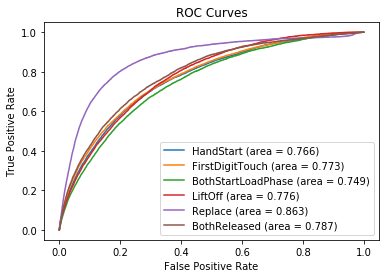

Mean AUC Score of Subject 1: 0.786


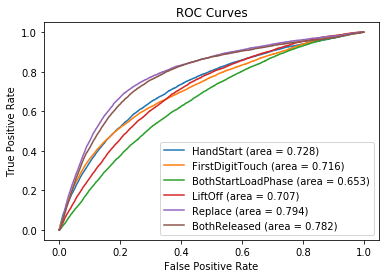

Mean AUC Score of Subject 2: 0.730


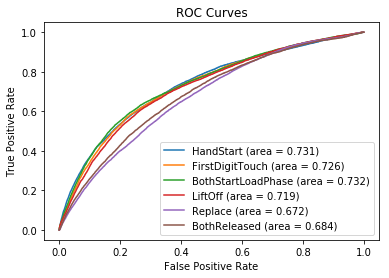

Mean AUC Score of Subject 3: 0.711


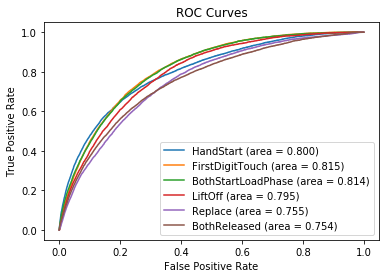

Mean AUC Score of Subject 4: 0.789


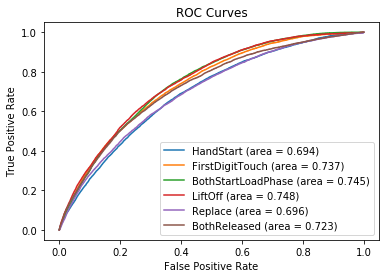

Mean AUC Score of Subject 5: 0.724


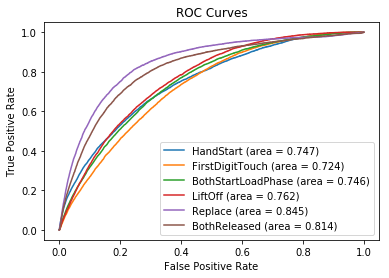

Mean AUC Score of Subject 6: 0.773


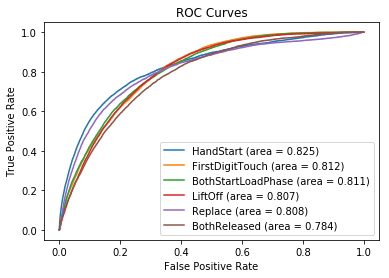

Mean AUC Score of Subject 7: 0.808


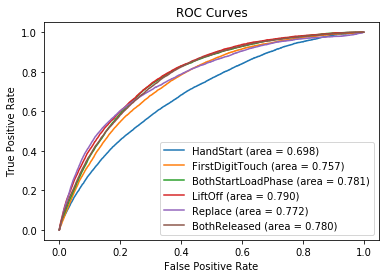

Mean AUC Score of Subject 8: 0.763


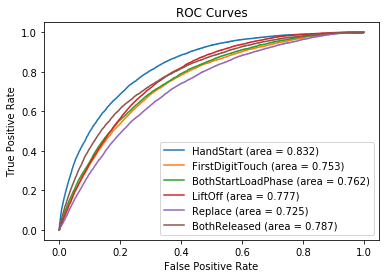

Mean AUC Score of Subject 9: 0.773


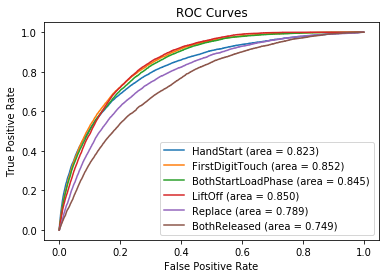

Mean AUC Score of Subject 10: 0.818


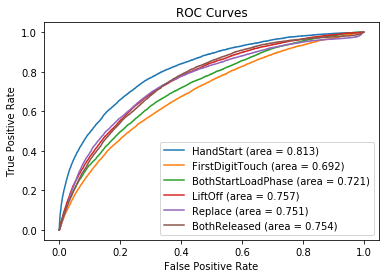

Mean AUC Score of Subject 11: 0.748


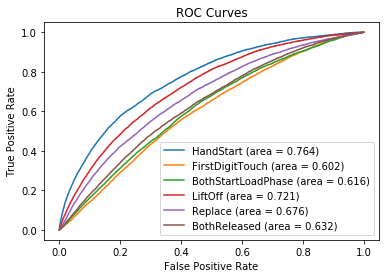

Mean AUC Score of Subject 12: 0.669


In [36]:
scores = all_auc_scores(prediction_total, test_data_total, SUBJECTS, with_plot=True)

In [37]:
print('Mean Columnwise AUC ROC Score: %.3f, %.3f' % (np.mean(scores), np.std(scores)))

Mean Columnwise AUC ROC Score: 0.758, 0.055


In [38]:
#########################KAGGLE SUBMISSION CODE

# prediction_total= []
# ids_total = []
# for subject in SUBJECTS:
#     test_features_raw = []
#     train_data_paths = glob(TRAIN_DATA_PATH % (subject))
#     test_data_paths =  glob(TEST_DATA_PATH % (subject))
  
#     x_train, y_train = read_training_data(train_data_paths)
#     x_test, ids = read_test_data(test_data_paths)
#     ids_total.append(ids)
    
    
    
    #Below you can put preprocessing functions. You can make a decision in which method to use
    #by commenting certain lines or not.#     x_train = butter_worth(x_train, CUTT_OFF_FREQUENCY, SAMPLE_FREQUENCY, ORDER)
#     x_test = butter_worth(x_test, CUTT_OFF_FREQUENCY, SAMPLE_FREQUENCY, ORDER)
#     x_train, pca_model = pca_transform(x_train, PCA_COMPONENTS, None)
#     x_test = pca_transform(x_test, PCA_COMPONENTS, pca_model)
#     x_train, scaler = scaler_transform(x_train, None)
#     x_test = scaler_transform(x_test, scaler)
#     #############################################
    
#     predictions = np.empty((x_test.shape[0],6))
#     #Below you define the model you want to use.
#     logreg = LogisticRegression()
#     for i in range(N_LABELS):
#         print('Train subject %d, class %s' % (subject, COLUMNS[i]))
#         model = train_model(x_train, y_train[:,i], logreg, SUBSAMPLE)
#         predictions[:,i] = make_prediction(x_test, model)
        
#     prediction_total.append(predictions)

# make_submission_file(SUBMISSION_NAME, ids_total, prediction_total, COLUMNS, SUBMISSION_FOLDER)